In this notebook, we assess the deployment of CDR across different pathway classifications. We want to decompose the different roles that CDR plays, namely:
* Balancing residual CO2 emissions 
* Balancing residual greenhouse gas emissions 
* Further scenario-assumption dependent cooling

In [1]:
import pyam 
from silicone.utils import convert_units_to_MtCO2_equiv
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns 
import numpy as np
import pandas as pd  
from pathlib import Path 
import string
plt.style.use("plotting_template.mplstyle")

<IPython.core.display.Javascript object>

# Read in data 

In [2]:
data_folder = Path("../data")

In [3]:
df_sr15 = pyam.IamDataFrame(
    Path(data_folder / "sr15_downselected.xlsx")
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/sr15_downselected.xlsx
pyam.core - INFO: Reading meta indicators


In [4]:
df_sr15.load_meta(
    Path(data_folder / "sr15_updated_meta.xlsx")
)

pyam.core - INFO: Reading meta indicators


In [5]:
df_engage = pyam.IamDataFrame(
    Path(data_folder / "engage_downselected.xlsx")
)

pyam.core - INFO: Reading file ../data/engage_downselected.xlsx
pyam.core - INFO: Reading meta indicators


In [6]:
df_engage.load_meta(
    Path(data_folder / "engage_updated_meta.xlsx")
)

pyam.core - INFO: Reading meta indicators


In [7]:
df_engage.rename(
    variable = {
        "Emissions|Kyoto Gases":"Emissions|Kyoto Gases (AR5-GWP100)"
    }, 
    inplace = True
)

# Data processing

In [8]:
variables_of_interest = [ 
    "Carbon Sequestration*",
    "Emissions|CO2|AFOLU", 
    "Emissions*", 
    "AR5 climate diagnostics|Temperature*"
]

In [9]:
df_sr15 = df_sr15.filter(variable = variables_of_interest)
df_engage = df_engage.filter(variable = variables_of_interest)

## How many variables report all carbon sequestration variables?

In [10]:
cs_variables_to_check = [
    "Carbon Sequestration|CCS|Biomass", 
    "Carbon Sequestration|Land Use", 
    "Emissions|CO2|AFOLU"
]

In [11]:
for var in cs_variables_to_check:
    df_sr15.filter(category_new = "PA*").require_variable(var)

pyam.core - INFO: All scenarios have the required variable `Carbon Sequestration|CCS|Biomass`
pyam.core - INFO: 54 scenarios do not include required variable `Carbon Sequestration|Land Use`
pyam.core - INFO: All scenarios have the required variable `Emissions|CO2|AFOLU`


In [12]:
for var in cs_variables_to_check:
    df_engage.filter(category_new = "PA*").require_variable(var)

pyam.core - INFO: 11 scenarios do not include required variable `Carbon Sequestration|CCS|Biomass`
pyam.core - INFO: 19 scenarios do not include required variable `Carbon Sequestration|Land Use`
pyam.core - INFO: All scenarios have the required variable `Emissions|CO2|AFOLU`


## Handling missing AFOLU sequestration
We should use the net AFOLU emissions then, in line with the approach adopted in Warszawski et al. This should then be interpreted as an upper bound on removals (actual removals could be higher)

In [13]:
df_compiled = (
    df_sr15
    .append(df_engage)
    .filter(
        category = [
            "Below 1.5C", 
            "1.5C low overshoot",
            "1.5C high overshoot"
        ],
        netzero = True
        #category_new = ["PA (Art 2 and 4)"]
    )
    .filter(model = "GEM-E3*", keep = False)
)

In [14]:
df_compiled.require_variable(
    "Emissions|Kyoto Gases (AR5-GWP100)", 
    exclude_on_fail = True 
)
df_compiled.filter(exclude = False, inplace=True)

pyam.core - INFO: All scenarios have the required variable `Emissions|Kyoto Gases (AR5-GWP100)`


At minimum, we need all scenarios to report emissions from kyoto gases, and CO2 emissions. We exclude those that do not.

In [15]:
co2_afolu = (
    df_compiled
    .filter(variable = "Emissions|CO2|AFOLU")
    .timeseries()
)

In [16]:
co2_afolu_nn = co2_afolu.applymap(lambda x: -min(x,0)).reset_index()
co2_afolu_nn.variable = "Carbon Sequestration|AFOLU"

In [17]:
co2_afolu_nn_pyam = pyam.IamDataFrame(co2_afolu_nn)

Diagnostic test: Check that all these quantities are positive.

In [18]:
co2_afolu_nn_pyam.validate(
    criteria = {"Carbon Sequestration|AFOLU": {"lo": 0}}
)

In [19]:
df_compiled.append( 
    co2_afolu_nn_pyam, 
    inplace = True 
)

## Kyoto Gases (AR5-GWP100)

In [20]:
kyoto_gases_excl_co2 = [ 
    "Emissions|N2O",
    "Emissions|CH4",
    "Emissions|SF6",
    "Emissions|HFC|HFC125",
    "Emissions|HFC|HFC134a",
    "Emissions|HFC|HFC143a",
    "Emissions|HFC|HFC227ea",
    "Emissions|HFC|HFC23",
    "Emissions|HFC|HFC32",
    "Emissions|HFC|HFC245fa",
    "Emissions|HFC|HFC43-10",
    "Emissions|PFC|C2F6",
    "Emissions|PFC|C6F14",
    "Emissions|PFC|CF4"       
]

In [21]:
kyotoghg_excl_co2 = df_compiled.filter(
    variable = kyoto_gases_excl_co2
).rename(
    unit = {"kt HFC43-10/yr":"kt HFC4310/yr"}
)

In [22]:
kyotoghg_mtco2eq = convert_units_to_MtCO2_equiv(kyotoghg_excl_co2)

In [23]:
kyotoghg_mtco2eq.aggregate(
    variable = "Emissions|KyotoGHG|excl. CO2", 
    components = kyoto_gases_excl_co2, 
    append=True 
)

In [24]:
df_compiled.append(
    kyotoghg_mtco2eq.filter(variable = "Emissions|KyotoGHG|excl. CO2"), 
    inplace=True
)

# Handling DAC
## The REMIND series in the data has the wrong sign

In [25]:
dac_remind = df_compiled.filter(
    model = "REMIND-MAgPIE 2.1-4.2", 
    variable = "Carbon Sequestration|Direct Air Capture", 
    region = "World"
)

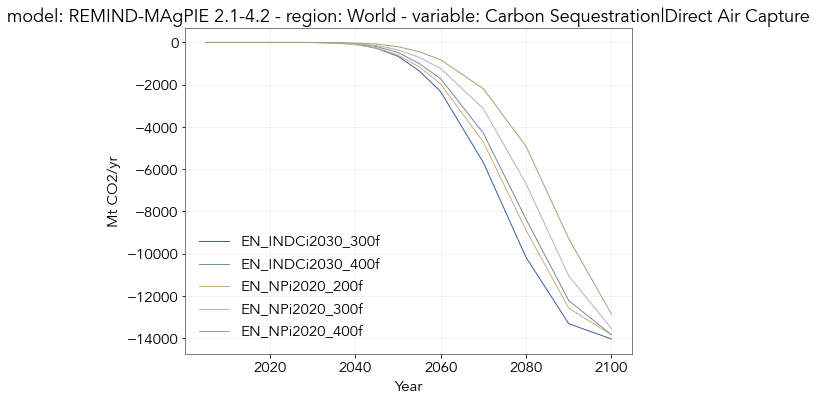

In [26]:
dac_remind.plot()

In [27]:
dac_remind.convert_unit(
    current = "Mt CO2/yr", 
    to = "Mt CO2/yr", 
    factor = -1, 
    inplace = True
)

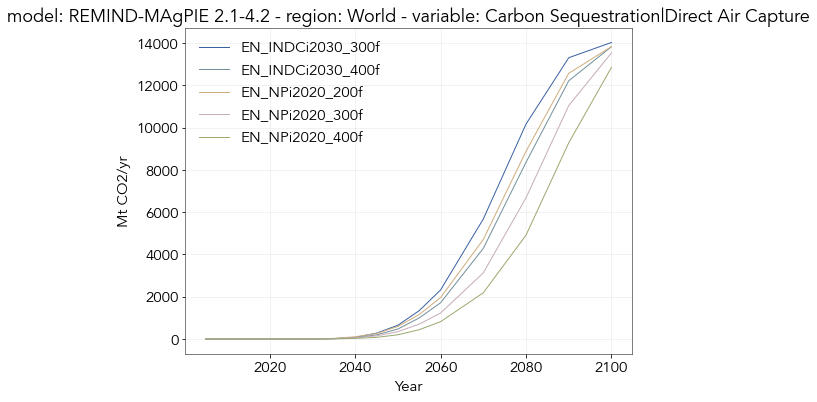

In [28]:
dac_remind.plot()

In [29]:
df_compiled.filter(
    model = "REMIND-MAgPIE 2.1-4.2", 
    variable = "Carbon Sequestration|Direct Air Capture", 
    keep = False, 
    inplace = True
)

In [30]:
df_compiled.append(
    dac_remind, 
    inplace = True
)

pyam.plotting - INFO: >=13 labels, not applying legend


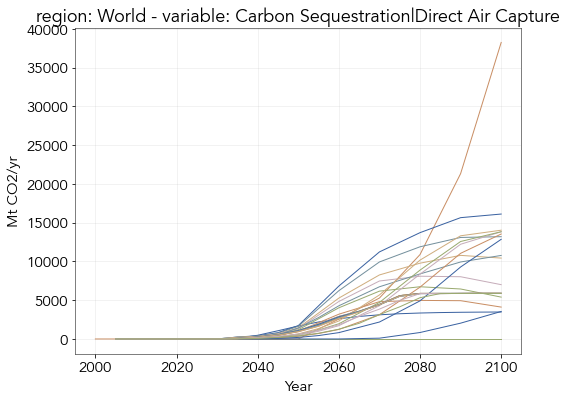

In [31]:
df_compiled.filter(
    variable = "Carbon Sequestration|Direct Air Capture"
).plot()

# Compile a complete CDR variable

In [32]:
df_compiled.aggregate(
    variable = "Carbon Dioxide Removal", 
    components = [ 
        "Carbon Sequestration|CCS|Biomass", 
        "Carbon Sequestration|AFOLU", 
        "Carbon Sequestration|Direct Air Capture" #For some REMIND and WITCH scenarios
    ], 
    append = True
)

# Figure 3
## Illustrative pathways achieving net zero GHG emissions

In [33]:
# Make lines thicker in the plot
plt.rcParams['lines.linewidth'] = 1.5

In [34]:
pathways_colors = [ 
    ("WITCH-GLOBIOM 3.1", "SSP4-19", "#e69f25"), # Achieve zero, but high GHG emissions
    ("AIM/CGE 2.0", "SSP1-19", "#069f72"), # Achieve zero, low non CO2
    ("POLES ADVANCE", "ADVANCE_2020_1.5C-2100", "#0773b2")
]

In [35]:
def plotting_helper(variable, ax, **kwargs):
    for mod, scen, color in pathways_colors:
        plot_data = df_compiled.filter(
            model = mod, 
            scenario = scen, 
            variable = variable
        )
        plot_data.convert_unit(current = "Mt CO2/yr", to="Gt CO2/yr", inplace = True)
        plot_data.convert_unit(current = "Mt CO2-equiv/yr", to = "Gt CO2-equiv/yr", inplace=True)
        plot_data.plot(
            ax = ax,
            color = color, 
            **kwargs
        )
        if variable in ["Emissions|Kyoto Gases (AR5-GWP100)", "AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED"]:
            _vertline = df_compiled.filter( 
                model = mod, 
                scenario = scen
            ).meta["netzero|kyotoghg"].values[0]
            print(_vertline)
            ax.axvline(_vertline, color = color, alpha=0.4)
    ax.set_title("")

2075.0
2067.0
2059.0
2075.0
2067.0
2059.0


[Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '-5'),
 Text(0, 0, '-10'),
 Text(0, 0, '-15'),
 Text(0, 0, '-20')]

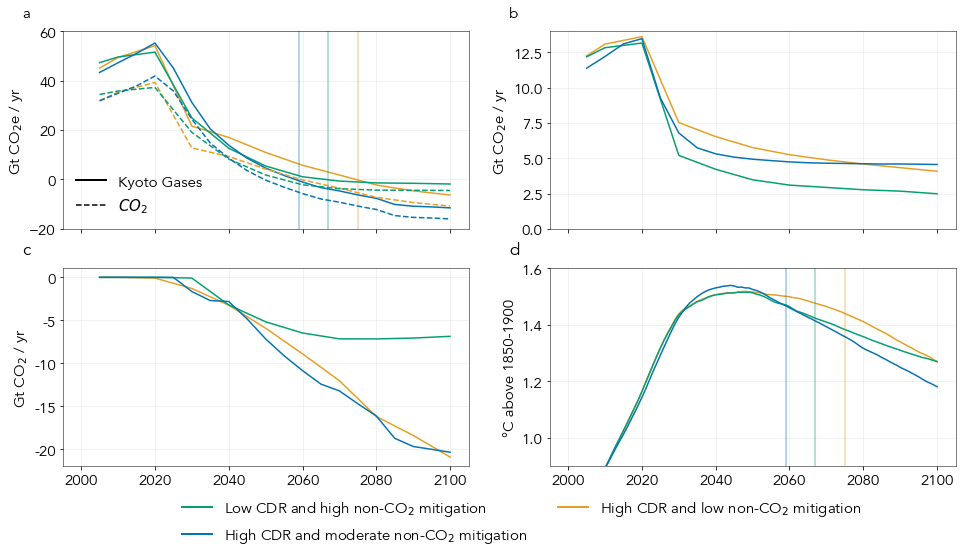

In [36]:
fig, ax = plt.subplots(2,2, sharex=True, figsize=(16,8))
leg_str = list()
plotting_helper("Carbon Dioxide Removal", ax=ax[1,0]) # Panel C
plotting_helper("Emissions|Kyoto Gases (AR5-GWP100)", ax=ax[0,0]) # Add CO2 and shift to Panel A + vertical for time of n zero GHG
plotting_helper("Emissions|KyotoGHG|excl. CO2", ax=ax[0,1]) # Non CO2 is Panel B
plotting_helper("AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED", ax=ax[1,1]) # Panel D
plotting_helper("Emissions|CO2", ax=ax[0,0], linestyle="dashed")

# Update axes
ax[0,0].set_ylim(-20, 60)
ax[0,1].set_ylim(0,14)
ax[1,1].set_ylim(0.9, 1.6)

# Add annotations
for n, a in enumerate(ax[0]):
    a.set_xlabel("")
    a.text(
        -0.1, 1.07, 
        string.ascii_lowercase[n], 
        transform=a.transAxes,
        size=15, 
        weight='bold'
    )

for n, a in enumerate(ax[1]):
    a.set_xlabel("")
    a.text(
        -0.1, 1.07, 
        string.ascii_lowercase[n+2], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )

# Construct a custom legend
custom_legend = [ 
    Line2D([0], [0], color = "black", lw=2, label = "Kyoto Gases"),
    Line2D([0], [0], color = "black", label = "$CO_2$", linestyle = "dashed")
]

# Plot details
ax[0,0].legend(
    handles=custom_legend, 
)

second_custom_legend = [
    Line2D([0], [0], color = "#069f72", lw=2, label = "Low CDR and high non-CO$_2$ mitigation"), 
    Line2D([0], [0], color = "#0773b2", lw=2, label = "High CDR and moderate non-CO$_2$ mitigation"), 
    Line2D([0], [0], color = "#e69f25", lw=2, label = "High CDR and low non-CO$_2$ mitigation")
]

ax[1,0].legend(
    handles = second_custom_legend, 
    ncol = 2, 
    bbox_to_anchor = (2, -0.1)
)

# Y labels 
ax[0,0].set_ylabel("Gt CO$_2$e / yr")
ax[1,0].set_ylabel("Gt CO$_2$ / yr")
ax[0,1].set_ylabel("Gt CO$_2$e / yr")
ax[1,1].set_ylabel("°C above 1850-1900")

ax[1,0].invert_yaxis()
ax[1,0].set_yticklabels([0, 0, -5, -10 ,-15, -20])

In [37]:
fig.savefig(
    Path("figures/Figure 4.png")
)

# Assign year of net zero CO2 emissions
We have already assigned the year of net zero greenhouse gas emissions in a previous figure.

In [38]:
def _cross_threshold(x):
    y = pyam.cross_threshold(x, threshold=0.1)
    # set threshold slightly above 0 to catch convergence to 0
    return y[0] if len(y) else 2101 #I adapt this to 2101 to catch the >2100 explicitly

def calculate_netzero(_df):
    return _df.apply(_cross_threshold, raw=False, axis=1)

In [39]:
co2 = (
    df_compiled
    .filter(variable = "Emissions|CO2")
    .timeseries()
)

In [40]:
df_compiled.set_meta(
    calculate_netzero(co2),
    "netzero|CO2"
)

In [41]:
kyoto_gases = (
    df_compiled 
    .filter(variable = "Emissions|Kyoto Gases (AR5-GWP100)")
    .timeseries()
)

In [42]:
df_compiled.set_meta(
    calculate_netzero(kyoto_gases), 
    "netzero|KyotoGHG"
)

In [43]:
# Interpolate CDR for all years
df_compiled.interpolate(
    time = range(2020,2101), 
    inplace=True
)

# Level calculation
## CDR at net zero CO2
### Step 1: Calculate the level at net zero CO2
I apply a variation of the function from [here](https://data.ene.iiasa.ac.at/sr15_scenario_analysis/assessment/sr15_2.0_categories_indicators.html)

In [44]:
def get_from_meta_column(df, x, col):
    val = df.meta.loc[x.name[0:2], col]
    return val if val < 2101 else 2100

In [45]:
cdr = (
    df_compiled
    .filter(
        variable = "Carbon Dioxide Removal"
    )
    .timeseries()
)

In [46]:
df_compiled.set_meta(
    name = "CDR|level|netzeroCO2", 
    meta = cdr.apply(
        lambda x: x[get_from_meta_column(df_compiled, x, "netzero|CO2")], 
        axis = 1
    )
)

### Step 2: Calculate the cumulative amount till 2100 assuming constant level

In [47]:
df_compiled.set_meta(
    df_compiled.meta.apply(
        lambda x: x["CDR|level|netzeroCO2"] * (x["netzero|KyotoGHG"] - x["netzero|CO2"]), 
        axis=1
    ), 
    name = "Cumulative|CDR|CO2|netzeroCO2-netzeroKyotoGHG|Constant Level"
)

## CDR for kyoto greenhouse gases

In [48]:
kyoto_gases_excl_co2 = (
    df_compiled
    .filter(variable = "Emissions|KyotoGHG|excl. CO2")
    .timeseries()
)

In [49]:
df_compiled.set_meta(
    kyoto_gases_excl_co2.apply(
        lambda x: pyam.cumulative(
            x, 
            first_year = get_from_meta_column(df_compiled, x, "netzero|CO2"), 
            last_year = get_from_meta_column(df_compiled, x, "netzero|KyotoGHG"), 
        ), 
        axis=1
    ), 
    name = "Cumulative|CDR|KyotoGHG|netzeroCO2-netzeroGHG"
)

# CDR total deployed

In [50]:
cdr = (
    df_compiled
    .filter(variable = "Carbon Dioxide Removal")
    .timeseries()
)

In [51]:
df_compiled.set_meta(
    cdr.apply(
        lambda x: pyam.cumulative(
            x, 
            first_year = get_from_meta_column(df_compiled, x, "netzero|CO2"), 
            last_year = get_from_meta_column(df_compiled, x, "netzero|KyotoGHG")
        ), 
        axis=1
    ), 
    name = "Cumulative|CDR|netzeroCO2-netzeroGHG"
)

In [52]:
df_compiled.set_meta(
    df_compiled.meta.apply(
        lambda x: x["Cumulative|CDR|netzeroCO2-netzeroGHG"] - (x["Cumulative|CDR|KyotoGHG|netzeroCO2-netzeroGHG"] + x["Cumulative|CDR|CO2|netzeroCO2-netzeroKyotoGHG|Constant Level"]), 
        axis = 1
    ), 
    name = "Delta|CDR|netzeroCO2-netzeroGHG"
)

In [53]:
df_compiled.meta["Delta|CDR|netzeroCO2-netzeroGHG"].describe()

count       109.000000
mean     -54144.978770
std       41058.974654
min     -238567.355154
25%      -71153.499043
50%      -44536.382951
75%      -25433.310716
max          89.859111
Name: Delta|CDR|netzeroCO2-netzeroGHG, dtype: float64

Now, we add this to the cumulative estimate to "correct" the constant level assumption.

In [54]:
df_compiled.set_meta(
    df_compiled.meta.apply(
        lambda x: x["Cumulative|CDR|CO2|netzeroCO2-netzeroKyotoGHG|Constant Level"] + x["Delta|CDR|netzeroCO2-netzeroGHG"], 
        axis = 1   
    ), 
    name = "Cumulative|CDR|CO2|netzeroCO2-netzeroGHG|Corrected"
)

We calculate a new average level over the period to propagate forward.

In [55]:
df_compiled.set_meta(
    df_compiled.meta.apply(
        lambda x: x["Cumulative|CDR|CO2|netzeroCO2-netzeroGHG|Corrected"] / (x["netzero|KyotoGHG"] - x["netzero|CO2"]), 
        axis = 1   
    ), 
    name = "CDR|level|CO2|netzeroGHG"
)

In [56]:
df_compiled.meta[["CDR|level|netzeroCO2", "CDR|level|CO2|netzeroGHG"]].describe()

CDR|level|netzeroCO2  CDR|level|CO2|netzeroGHG
count            109.000000                109.000000
mean            9722.519777               5579.473846
std             3062.643469               2891.904339
min             2773.649988                620.882922
25%             7380.439918               3329.230676
50%            10084.819727               5438.660723
75%            11625.392403               7539.596486
max            22385.745680              17543.784675

# Now to the end of century..
## CO2 emissions

In [57]:
df_compiled.set_meta(
    df_compiled.meta.apply(
        lambda x: x["CDR|level|CO2|netzeroGHG"] * (2100 - x["netzero|KyotoGHG"]), 
        axis=1
    ), 
    name = "Cumulative|CDR|CO2|netzeroKyotoGHG-2100|Constant Level"
)

In [58]:
df_compiled.set_meta(
    kyoto_gases_excl_co2.apply(
        lambda x: pyam.cumulative(
            x, 
            first_year = get_from_meta_column(df_compiled, x, "netzero|KyotoGHG"), 
            last_year = 2100
        ), 
        axis=1
    ), 
    name = "Cumulative|CDR|KyotoGHG|netzeroGHG-2100"
)

In [59]:
df_compiled.set_meta(
    cdr.apply(
        lambda x: pyam.cumulative(
            x, 
            first_year = get_from_meta_column(df_compiled, x, "netzero|KyotoGHG"),
            last_year = 2100
        ), 
        axis=1
    ), 
    name = "Cumulative|CDR|netzeroGHG-2100"
)

In [60]:
df_compiled.set_meta(
    df_compiled.meta.apply(
        lambda x: x["Cumulative|CDR|netzeroGHG-2100"] - (x["Cumulative|CDR|KyotoGHG|netzeroGHG-2100"] + x["Cumulative|CDR|CO2|netzeroKyotoGHG-2100|Constant Level"]), 
        axis = 1
    ), 
    name = "Delta|CDR|netzeroGHG-2100"
)

In [61]:
## Additional assumptions
df_compiled.set_meta(
    df_compiled.meta.apply(
        lambda x: x["Delta|CDR|netzeroGHG-2100"] if x["Delta|CDR|netzeroGHG-2100"] > 0 else 0, 
        axis = 1
    ), 
    name = "Amount|CDR|Additional Assumptions"
)

In [62]:
df_compiled.set_meta(
    df_compiled.meta.apply(
        lambda x: 100 *  x["Delta|CDR|netzeroGHG-2100"] / (x["Cumulative|CDR|netzeroCO2-netzeroGHG"] + x["Cumulative|CDR|netzeroGHG-2100"]) if x["Delta|CDR|netzeroGHG-2100"] > 0 else 0, 
        axis = 1
    ), 
    name = "Proportion|CDR|Additional Assumptions"
)

In [63]:
## CDR for KyotoGHG
df_compiled.set_meta(
    df_compiled.meta.apply(
        lambda x: x["Cumulative|CDR|KyotoGHG|netzeroGHG-2100"] + x["Cumulative|CDR|KyotoGHG|netzeroCO2-netzeroGHG"], 
        axis = 1
    ), 
    name = "Amount|CDR|KyotoGHG"
)

In [64]:
df_compiled.set_meta(
    df_compiled.meta.apply(
        lambda x: 100 * (x["Cumulative|CDR|KyotoGHG|netzeroGHG-2100"] + x["Cumulative|CDR|KyotoGHG|netzeroCO2-netzeroGHG"]) / (x["Cumulative|CDR|netzeroCO2-netzeroGHG"] + x["Cumulative|CDR|netzeroGHG-2100"]), 
        axis = 1
    ), 
    name = "Proportion|CDR|KyotoGHG"
)

In [65]:
## CDR for CO2
df_compiled.set_meta( 
    df_compiled.meta.apply(
        lambda x: x["Cumulative|CDR|CO2|netzeroCO2-netzeroGHG|Corrected"] + x["Cumulative|CDR|CO2|netzeroKyotoGHG-2100|Constant Level"]
        if x["Delta|CDR|netzeroGHG-2100"] > 0 
        else x["Cumulative|CDR|CO2|netzeroCO2-netzeroGHG|Corrected"] + x["Cumulative|CDR|CO2|netzeroKyotoGHG-2100|Constant Level"] , 
        axis = 1
    ), 
    name = "Amount|CDR|CO2"    
)

In [66]:
df_compiled.set_meta(
    df_compiled.meta.apply(
        lambda x: 100 * (x["Cumulative|CDR|CO2|netzeroCO2-netzeroGHG|Corrected"] + x["Cumulative|CDR|CO2|netzeroKyotoGHG-2100|Constant Level"]) / (x["Cumulative|CDR|netzeroCO2-netzeroGHG"] + x["Cumulative|CDR|netzeroGHG-2100"])
        if x["Delta|CDR|netzeroGHG-2100"] > 0 
        else 100 * (x["Cumulative|CDR|CO2|netzeroCO2-netzeroGHG|Corrected"] + x["Cumulative|CDR|CO2|netzeroKyotoGHG-2100|Constant Level"] + x["Delta|CDR|netzeroGHG-2100"]) / (x["Cumulative|CDR|netzeroCO2-netzeroGHG"] + x["Cumulative|CDR|netzeroGHG-2100"]), 
        axis = 1
    ), 
    name = "Proportion|CDR|CO2"
)

In [67]:
plot_data = df_compiled.meta[[
    "category", 
    "category_new",
    "Proportion|CDR|CO2", 
    "Amount|CDR|CO2",
    "Proportion|CDR|KyotoGHG", 
    "Amount|CDR|KyotoGHG",
    "Proportion|CDR|Additional Assumptions", 
    "Amount|CDR|Additional Assumptions"  
]]

In [68]:
plot_data["Proportion|CDR|Balance"] = plot_data["Proportion|CDR|CO2"] + plot_data["Proportion|CDR|KyotoGHG"]

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_26058/1136359407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["Proportion|CDR|Balance"] = plot_data["Proportion|CDR|CO2"] + plot_data["Proportion|CDR|KyotoGHG"]


In [69]:
data = plot_data[plot_data.category_new == "PA (Art 2 and 4)"][[
    "Proportion|CDR|CO2", 
    "Amount|CDR|CO2",
    "Proportion|CDR|KyotoGHG", 
    "Amount|CDR|KyotoGHG",
    "Proportion|CDR|Additional Assumptions", 
    "Amount|CDR|Additional Assumptions"    
]]

In [70]:
lo_os_data = plot_data[[
    "Proportion|CDR|CO2", 
    "Amount|CDR|CO2",
    "Proportion|CDR|KyotoGHG", 
    "Amount|CDR|KyotoGHG",
    "Proportion|CDR|Additional Assumptions", 
    "Amount|CDR|Additional Assumptions"    
]]

# SI Figure

In [71]:
plt.rcParams.update({'mathtext.default':  'regular' })

In [72]:
plot_data["cats_for_plot"] = plot_data.apply(
    lambda x: x["category_new"] if x["category_new"] == "PA (Art 2 and 4)" else x["category"], 
    axis = 1
)

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_26058/3739811373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["cats_for_plot"] = plot_data.apply(


In [73]:
cats_for_plot = [ 
    "Below 1.5C", 
    "PA (Art 2 and 4)", 
    "1.5C low overshoot", 
    "1.5C high overshoot"
]

In [74]:
colors = { 
    "PA (Art 2 and 4)":"#6abeae", 
    "Below 1.5C":"#8ad0e2", 
    "1.5C low overshoot":"#808eaf", 
    "1.5C high overshoot":"#e76562"    
}
labels = { 
    "PA (Art 2 and 4)":"Paris Agreement (Article 2 and 4)", 
    "Below 1.5C":"Below 1.5°C (excluding PA)", 
    "1.5C low overshoot":"1.5°C low overshoot (excluding PA)", 
    "1.5C high overshoot":"1.5°C high overshoot"    
}

In [75]:
vars_to_plot_panel_1 = [ 
    "Amount|CDR|CO2", 
    "Amount|CDR|KyotoGHG", 
    "Amount|CDR|Additional Assumptions"
]

vars_to_plot_panel_2 = [ 
    "Proportion|CDR|CO2", 
    "Proportion|CDR|KyotoGHG", 
    "Proportion|CDR|Additional Assumptions"    
]

In [76]:
# Helper functions
def box_plotter(vars_to_plot, ax):
    for i, cat in enumerate(cats_for_plot):
        for j,var in enumerate(vars_to_plot):
            if var.startswith("Amount"):
                _data = plot_data[ 
                    (plot_data["cats_for_plot"] == cat)
                ][var]/1e3
            else:
               _data = plot_data[ 
                    (plot_data["cats_for_plot"] == cat)
                ][var] 
            pos = (0.75 / _len * (i - _len/2) + j)
            if len(_data) >= min_points:
                p = ax.boxplot(
                    _data, positions = [pos], widths = 0.08, 
                    patch_artist = True, 
                )
                plt.setp(p['boxes'], color=colors[cat])
                plt.setp(p['medians'], color='black')

            else:
                ax.scatter(x=[pos] * len(_data), y=_data, zorder=6,
                            edgecolors='black', marker='o',
                                s=30, label=None, color = colors[cat])
        ax.plot([], c=colors[cat], label='{} [{}]'.format(labels[cat], len(_data)))
    ax.set_xlim(-0.6, 2.7)
    ax.set_xticks(
        range(0, len(vars_to_plot))
    ) 
    ax.set_xticklabels(
        [ 
            "CDR for\n$CO_2$", 
            "CDR for \nKyoto GHG", 
            "Additional\nCDR"
        ]      
    )

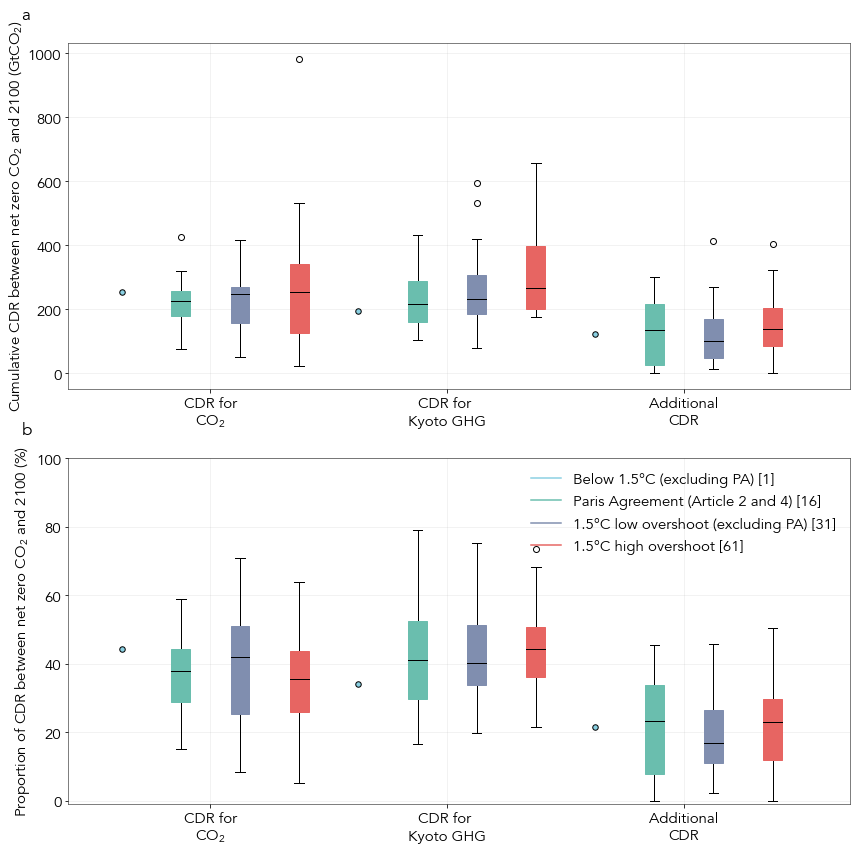

In [77]:
fig, ax = plt.subplots(2, 1, figsize=(14,14))

_len = len(cats_for_plot) - 1
min_points = 10 # Nature data requirements
box_plotter(vars_to_plot_panel_1, ax[0])
box_plotter(vars_to_plot_panel_2, ax[1])

ax[0].set_ylabel("Cumulative CDR between net zero $CO_2$ and 2100 ($GtCO_2$)")
ax[1].set_ylabel("Proportion of CDR between net zero $CO_2$ and 2100 (%)")
ax[1].set_ylim(-1,100)
ax[1].legend()

# Annotations 
for n,a in enumerate(ax):
    a.text(
        -0.06, 1.07, 
        string.ascii_lowercase[n], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )
    a.set_xlabel("")

# Statistics for Table 2

In [78]:
stats_fig4 = (
    plot_data
    .groupby("cats_for_plot")
    .describe()
    .T
    .reset_index()
    .rename(
        columns = {
            "level_0": "variable", 
            "level_1":"statistic"
        }
    )
)

In [79]:
stats_fig4 = stats_fig4[
    stats_fig4["statistic"].isin(["25%", "50%", "75%"])
].set_index("variable", "statistic")

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_26058/93757721.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  stats_fig4 = stats_fig4[


In [80]:
stats_fig4.columns = [ 
    "statistic",
    "1.5C high overshoot", 
    "1.5C low overshoot (excl. PA)", 
    "Below 1.5C (excl. PA)", 
    "PA (Art 2 and 4)"
]

In [81]:
stats_fig4.to_excel(
    Path("tables/TableFig4.xlsx")
)

# Statistics for Table 2
* 2030 GHG emissions 
* Year of net zero CO2 emissions 
* Year of net zero GHG emissions
* Peak warming 
* Warming in 2100

In [82]:
# Kyoto GHG emissions
df_compiled.set_meta_from_data(
    name = "Emissions|KyotoGHG|2030", 
    variable = "Emissions|Kyoto Gases (AR5-GWP100)", 
    year = 2030 
)

In [83]:
# Peak warming
df_compiled.set_meta_from_data(
    name = "peak_warming",
    variable = "AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED", 
    method = np.max
)

In [84]:
# 2100 warming 
df_compiled.set_meta_from_data(
    name = "2100_warming", 
    variable = "AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED", 
    year = 2100
)

In [85]:
stats_data = df_compiled.meta[[
    "category", 
    "category_new", 
    "Emissions|KyotoGHG|2030", 
    "netzero|CO2", 
    "netzero|kyotoghg", 
    "peak_warming", 
    "2100_warming"
]]

In [86]:
stats_table2 = stats_data.groupby(
    ["category", "category_new"]
).describe()

In [87]:
stats_table2.T.to_excel(
    Path("tables/Table2.xlsx")
)

Joint distribution for the abstract.

In [88]:
stats_abstract = stats_data.groupby("category_new").describe().T

In [89]:
(stats_abstract.loc["Emissions|KyotoGHG|2030"]/1e3).round(1)

category_new  PA (Art 2 and 4)  PA (Art 4)
count                      0.0         0.1
mean                      22.1        38.0
std                        6.5         9.3
min                        6.5        19.2
25%                       20.2        31.6
50%                       23.3        35.2
75%                       26.4        46.3
max                       31.2        59.6

In [90]:
stats_abstract.loc["netzero|CO2"].round(0)

category_new  PA (Art 2 and 4)  PA (Art 4)
count                     16.0        93.0
mean                    2050.0      2058.0
std                        5.0         8.0
min                     2037.0      2043.0
25%                     2048.0      2051.0
50%                     2050.0      2058.0
75%                     2053.0      2064.0
max                     2060.0      2076.0

In [91]:
stats_abstract.loc["netzero|kyotoghg"].round(0)

category_new  PA (Art 2 and 4)  PA (Art 4)
count                     16.0        93.0
mean                    2063.0      2070.0
std                       10.0         8.0
min                     2045.0      2051.0
25%                     2057.0      2064.0
50%                     2060.0      2071.0
75%                     2067.0      2075.0
max                     2087.0      2088.0

In [92]:
stats_abstract.loc["peak_warming"].round(2)

category_new  PA (Art 2 and 4)  PA (Art 4)
count                    16.00       93.00
mean                      1.50        1.65
std                       0.03        0.08
min                       1.43        1.50
25%                       1.48        1.60
50%                       1.51        1.64
75%                       1.53        1.70
max                       1.54        1.86

In [93]:
stats_abstract.loc["2100_warming"].round(2)

category_new  PA (Art 2 and 4)  PA (Art 4)
count                    16.00       93.00
mean                      1.18        1.37
std                       0.10        0.08
min                       1.01        1.17
25%                       1.12        1.30
50%                       1.22        1.36
75%                       1.26        1.44
max                       1.28        1.49

# Figure 5

In [94]:
data_fig5 = df_compiled.filter(
    category_new = "PA (Art 2 and 4)"
).meta

In [95]:
data_fig5["Total CDR"] = (
    data_fig5["Amount|CDR|CO2"]
    +
    data_fig5["Amount|CDR|KyotoGHG"]
    +
    data_fig5["Amount|CDR|Additional Assumptions"]
)

In [96]:
data_fig5 = data_fig5.sort_values(by = "Total CDR", ascending=False)

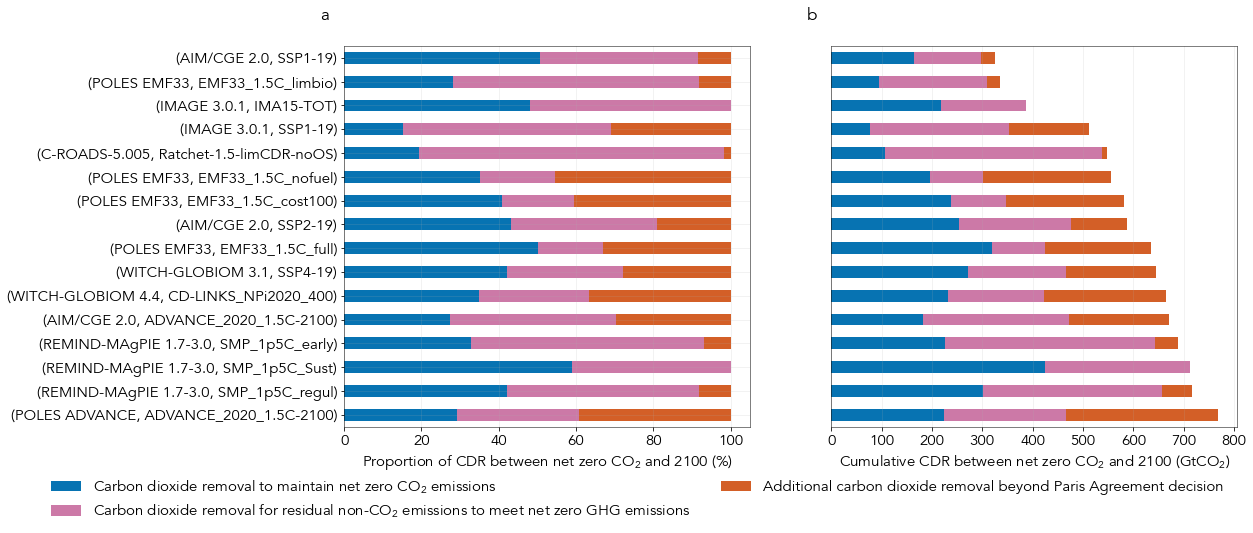

In [97]:
fig, ax = plt.subplots(1,2, figsize=(16,7))
# Panel 1: Waterfall chart
data_fig5[["Proportion|CDR|CO2", "Proportion|CDR|KyotoGHG", "Proportion|CDR|Additional Assumptions"]].plot.barh(
    stacked=True, 
    ax=ax[0], 
    color=["#0773b2",  "#cc79a7", "#d35f27"]
)
ax[0].set_ylabel("")
ax[0].set_xlabel("Proportion of CDR between net zero $CO_2$ and 2100 (%)")

(data_fig5[["Amount|CDR|CO2", "Amount|CDR|KyotoGHG", "Amount|CDR|Additional Assumptions"]]/1e3).plot.barh(
    stacked=True, ax=ax[1], color=["#0773b2",  "#cc79a7", "#d35f27"])

ax[1].set_yticks([])
ax[1].set_xlabel("Cumulative CDR between net zero $CO_2$ and 2100 $(Gt CO_2)$")
ax[1].set_ylabel("")

# Annotations
for n,a in enumerate(ax):
    a.text(
        -0.06, 1.07, 
        string.ascii_lowercase[n], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )
    a.get_legend().remove()

# Custom legend 
legend_handles = [ 
    Patch(facecolor = "#0773b2", label = "Carbon dioxide removal to maintain net zero CO$_2$ emissions"), 
    Patch(facecolor = "#cc79a7", label = "Carbon dioxide removal for residual non-CO$_2$ emissions to meet net zero GHG emissions"), 
    Patch(facecolor = "#d35f27", label = "Additional carbon dioxide removal beyond Paris Agreement decision")
]
ax[1].legend(
    handles = legend_handles, 
    bbox_to_anchor = (1, -0.1), ncol=2
)

In [98]:
fig.savefig(
    Path("figures/Figure 5.png")
)

# Summary statistics

In [99]:
data_fig5[ 
    [ 
        "Proportion|CDR|CO2", 
        "Proportion|CDR|KyotoGHG", 
        "Proportion|CDR|Additional Assumptions",
        "Amount|CDR|CO2", 
        "Amount|CDR|KyotoGHG", 
        "Amount|CDR|Additional Assumptions"
    ]
].describe().T.to_excel(
    Path("tables/Table_for_Fig5.xlsx")
)